prepare data

In [2]:
import zipfile
import os
import sys

print("unzipping")
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip',"r") as z:
    z.extractall()    

print("creating folders")
for dataset in ["train","test"]:
    for label in [0,1]:
        try:
            os.makedirs("/kaggle/working/dataset/{}/{}".format(dataset,label))
        except OSError as e:
            print(e)
os.makedirs("/kaggle/working/out")

print("reorganizing data")
os.system("mv /kaggle/working/train/dog* /kaggle/working/dataset/train/0/.")
os.system("mv /kaggle/working/train/cat* /kaggle/working/dataset/train/1/.")
print(os.system("ls ./dataset/train/0 | shuf | head -n 1200 | xargs -I % mv /kaggle/working/dataset/train/0/% /kaggle/working/dataset/test/0/"))
print(os.system("ls ./dataset/train/1 | shuf | head -n 1200 | xargs -I % mv /kaggle/working/dataset/train/1/% /kaggle/working/dataset/test/1/"))

for dirname, _, filenames in os.walk('/kaggle/working/dataset'):
    print(dirname,len(filenames))

unzipping
creating folders
reorganizing data


shuf: write error: Broken pipe
shuf: write error


0


shuf: write error: Broken pipe
shuf: write error


0
/kaggle/working/dataset 0
/kaggle/working/dataset/train 0
/kaggle/working/dataset/train/0 11300
/kaggle/working/dataset/train/1 11300
/kaggle/working/dataset/test 0
/kaggle/working/dataset/test/0 1200
/kaggle/working/dataset/test/1 1200


experiments

e50_drop0_bn1_aug1_overfit1_ntrnALL

loading model
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_16 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pool

2022-12-12 22:52:47.477315: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-12 22:52:50.180914: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


565/565 [==============================] - 129s 215ms/step - loss: 0.7857 - accuracy: 0.5924 - val_loss: 0.7765 - val_accuracy: 0.5852

Epoch 00001: loss improved from inf to 0.78574, saving model to /kaggle/working/out/w_e50_drop0_bn1_aug1_overfit1_ntrnALL.h5
Epoch 2/50
565/565 [==============================] - 123s 217ms/step - loss: 0.5788 - accuracy: 0.6949 - val_loss: 0.6362 - val_accuracy: 0.6560

Epoch 00002: loss improved from 0.78574 to 0.57879, saving model to /kaggle/working/out/w_e50_drop0_bn1_aug1_overfit1_ntrnALL.h5
Epoch 3/50
565/565 [==============================] - 124s 219ms/step - loss: 0.5143 - accuracy: 0.7483 - val_loss: 0.5068 - val_accuracy: 0.7493

Epoch 00003: loss improved from 0.57879 to 0.51433, saving model to /kaggle/working/out/w_e50_drop0_bn1_aug1_overfit1_ntrnALL.h5
Epoch 4/50
565/565 [==============================] - 125s 221ms/step - loss: 0.4599 - accuracy: 0.7826 - val_loss: 0.6262 - val_accuracy: 0.7153

Epoch 00004: loss improved from 0.51433 

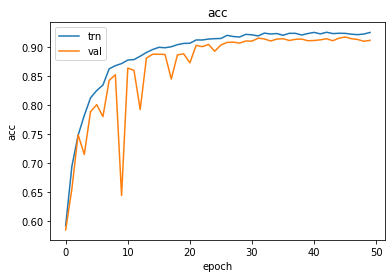

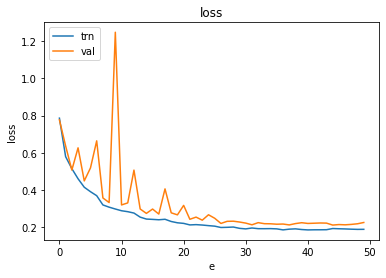

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 64)        0   

In [6]:
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from sklearn import metrics

class Const:
    def __init__(self):
        self.path_trn='/kaggle/working/dataset/train'
        self.path_tst='/kaggle/working/dataset/test'
        self.path_out='/kaggle/working/out'
        self.path_model="{}/w.h5".format(self.path_out)

        self.sz=(128, 128)
        self.is_overfitting=False
        self.is_aug=True

        self.dropout=0.25
        self.lr=.01
        self.decay_factor=.5
        self.decay_min_lr=.00001

        self.epochs=100
        self.bsz_infer=100
        self.val_split=.2
        self.batch_sz=20
        self.estop_pateience=10


def stats(ctrn,class_weights,const):
    cls = np.unique(ctrn)
    ntotal = sum([len(os.listdir("{}/{}".format(const.path_trn, c))) for c in cls])
    ntrn = int(ntotal * (1 - const.val_split))
    nval = int(ntotal * const.val_split)
    ntst = sum([len(os.listdir("{}/{}".format(const.path_tst, c))) for c in cls])
    print("class weights", class_weights, "ntrain", ntrn, "nval", nval, \
          "ntst", ntst, "trn_left", ntrn % const.batch_sz, "tst_left", ntst % const.batch_sz)
    return ntrn,nval,ntst


def get_gtrn(path, sz, validation_split, is_overfitting=False, is_aug=True):
    if is_aug:
        data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            horizontal_flip = True,
            validation_split=validation_split,
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2
        )
    else:
        data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=validation_split)
    tgen = data_gen.flow_from_directory(path, target_size=sz, class_mode='categorical', subset='training')
    if is_overfitting:
        vgen=tgen
    else:
        vgen = data_gen.flow_from_directory(path, target_size=sz, class_mode='categorical',subset='validation')
    return tgen, vgen


def get_gtst(path, sz):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    gen = data_gen.flow_from_directory(path, target_size=sz, class_mode='categorical')
    return gen


def load_model(sz,const):
    input = tf.keras.Input(shape=(sz[0], sz[1], 3))

    out=tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation="relu")(input)
    out=tf.keras.layers.BatchNormalization()(out)
    out=tf.keras.layers.MaxPooling2D()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)

    out=tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation="relu")(out)
    out=tf.keras.layers.BatchNormalization()(out)
    out=tf.keras.layers.MaxPooling2D()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)

    out=tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, activation="relu")(out)
    out=tf.keras.layers.BatchNormalization()(out)
    out=tf.keras.layers.MaxPooling2D()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)

    out=tf.keras.layers.Flatten()(out)
    out=tf.keras.layers.Dense(512, activation='relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)
    out=tf.keras.layers.Dense(2, activation='softmax')(out)

    model=tf.keras.models.Model(inputs=input, outputs=out)
    loss = tf.keras.losses.CategoricalCrossentropy()
    opt = tf.keras.optimizers.RMSprop(learning_rate=const.lr)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    model.summary()
    return model


def train(const,expr_name=""):
#    tf.debugging.set_log_device_placement(True)

    print("\nloading model",flush=True)
    model = load_model(const.sz,const)

    # prepare and balance data loaders
    print("\nloading training data",flush=True)
    gtrn, gval = get_gtrn(const.path_trn,const.sz, validation_split=const.val_split, \
                               is_overfitting=const.is_overfitting, is_aug=const.is_aug)
    ctrn = gtrn.classes
    class_weights = sklearn.utils.compute_class_weight(class_weight='balanced', classes=np.unique(ctrn), y=ctrn)
    class_weights = dict(zip(np.unique(ctrn), class_weights))

    # data stats
    print("data:",end=" ",flush=True)
    print(const.path_trn)
    stats(ctrn,class_weights,const)

    # train
    print("\ntraining",flush=True)
    ncpu = os. cpu_count()
    print("ncpu",ncpu)
    estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=const.estop_pateience, \
                                           verbose=2, mode="min", restore_best_weights=True)
    decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, \
                                                 factor=const.decay_factor, min_lr=const.decay_min_lr)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("{}/w_{}.h5".format(c.path_out, expr_name), \
                                                    monitor='loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(gtrn, validation_data=gval, epochs=const.epochs, \
                        class_weight=class_weights, callbacks=[estop, decay,checkpoint],
                        use_multiprocessing=True,workers=ncpu)
    model.save_weights(const.path_model)
    
    # training history visualization
    print("visualizing training process",flush=True)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['trn', 'val'], loc='upper left')
    #plt.savefig("{}/acc.jpg".format(const.path_out))
    plt.show()
    plt.close()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('e')
    plt.legend(['trn', 'val'], loc='upper left')
    #plt.savefig("{}/loss.jpg".format(const.path_out))
    plt.show()
    plt.close()

    
def eval(const):
    model=load_model(const.sz,const)
    model.load_weights(const.path_model)
    gtst=get_gtst(const.path_tst if not const.is_overfitting else const.path_trn,const.sz)
    test_scores = model.evaluate(x=gtst, verbose=2)
    print("loss",test_scores[0],"acc",test_scores[1])


if __name__=='__main__':
    """
    start: subset , im size 32x32 , overfit (im size 32x32) , rmsprop
    res: trn loss plateaue
    """
    expr_name = "e10_sz32_drop0_bn0_aug0_overfit1_ntrn1K"
    c = Const()
    c.path_trn = "/kaggle/working/dataset/train1000"
    c.epochs = 10
    c.dropout = 0
    c.is_overfitting = True
    c.is_aug = False
    c.sz = (32, 32)
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)

    """
    changes: all data
    res: trn loss plateaue
    """
    expr_name = "e50_sz32_drop0_bn0_aug0_overfit1_ntrnALL"
    c = Const()
    c.path_trn = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = 0
    c.is_overfitting = True
    c.is_aug = False
    c.sz = (32, 32)
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    changes: im size 128x128 , non overfit , aug
    res: trn loss plateaue
    """
    expr_name = "e100_drop0_bn1_aug1_overfit0_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 100
    c.dropout = 0
    c.is_overfitting = False
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    changes: overfit , dropout p=.25
    res: trn loss plateaue
    """
    expr_name = "e50_sz128_drop25_bn0_aug1_overfit1_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = .25
    c.is_overfitting = True
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    prev: e100_drop0_bn1_aug1_overfit0_ntrnALL
    changes: overfit , bn
    res: trn & val losses converges in 15e
    """
    expr_name = "e50_sz128_drop0_bn1_aug1_overfit1_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = 0
    c.is_overfitting = True
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    changes: eval test
    """
    expr_name = "e50_drop0_bn1_aug1_overfit1_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = 0
    c.is_overfitting = False
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    print(expr_name)
    train(c,expr_name)
    eval(c)